In [105]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model

In [106]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))
            


### Generation des images


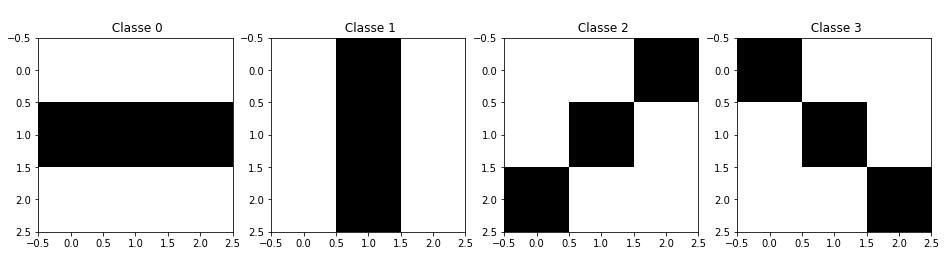

In [107]:
nb_classes=4
#Generation des 4 images de base => (4,3,3,1)
basepicture =np.zeros((4,3,3,1))
for m in range(4):
    if (m==0):
        #Horizontale        
        for j in range(3):
            basepicture[m,1,j,0] = 1
    if (m==1):
        #Vertical
        for j in range(3):
            basepicture[m,j,1,0] = 1
    if (m==2):
        #Diag
        for j in range(3):
            basepicture[m,2-j,j,0] = 1
    if (m==3):
        #Backslash
        for j in range(3):
            basepicture[m,j,j,0] = 1

basepictureH = basepicture[0,:,:,0]
basepictureV = basepicture[1,:,:,0]
basepictureD = basepicture[2,:,:,0]
basepictureB = basepicture[3,:,:,0]
fig=plt.figure(figsize=(16,16))
template=('\n Classe {}')
for classe in range(4):
    subplot = fig.add_subplot(1,4,classe+1)
    plt.imshow(basepicture[classe,:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text((template.format(classe)))





## Generation dataset

In [108]:
def buildDataSet(basepicture, nb_image_per_class=1, noise_amplitude=0.2):
    """Generation d'image en rajoutant du bruit sur les images de base
    
    
    returns:
        dataset : tableau (N) contenant les images pour chacune des classes (nb_image_per_class,3,3,1)
    """
    N,w,h,c = basepicture.shape
    
    SplitTrainTest = 0.7
    nb_train_sample = int(nb_image_per_class*SplitTrainTest)
    nb_test_sample = nb_image_per_class-nb_train_sample
    
    dataset_train = [np.zeros((nb_train_sample,h, w,c)) for i in range(N)]
    dataset_test = [np.zeros((nb_test_sample,h, w,c)) for i in range(N)]
    
    for n in range(N):
        #Genere la matrice de bruit pour toutes les images
        dataset_train[n] = np.random.uniform(-noise_amplitude,noise_amplitude,(nb_train_sample,w,h,c))
        dataset_test[n] = np.random.uniform(-noise_amplitude,noise_amplitude,(nb_test_sample,w,h,c))
        
        #Ajoute l'image de base au bruit existant
        for x in range(nb_train_sample):
            dataset_train[n][x,:,:,0] += basepicture[n,:,:,0]
            
        for x in range(nb_test_sample):
            dataset_test[n][x,:,:,0] += basepicture[n,:,:,0]
            
        #Clip les valeurs en dehors de 0 1
        dataset_train[n] = np.clip(dataset_train[n],0,1)
        dataset_test[n] = np.clip(dataset_test[n],0,1)
        
    return dataset_train,dataset_test



(700, 3, 3, 1)
(300, 3, 3, 1)
dataset train : 4x (700, 3, 3, 1)
dataset test : 4x (300, 3, 3, 1)


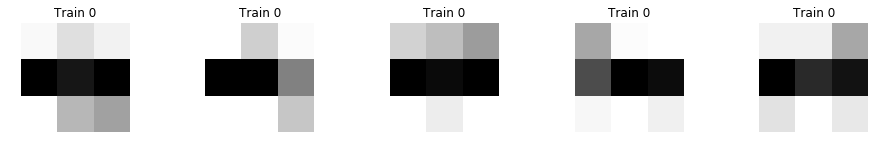

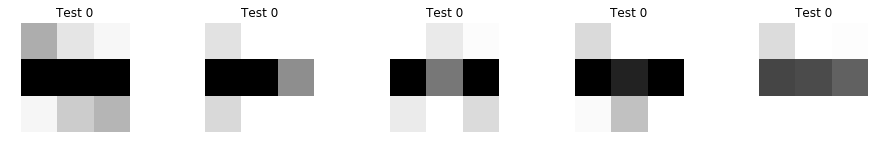

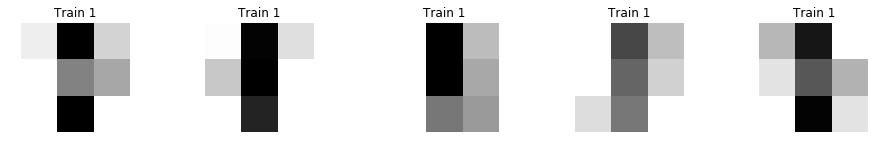

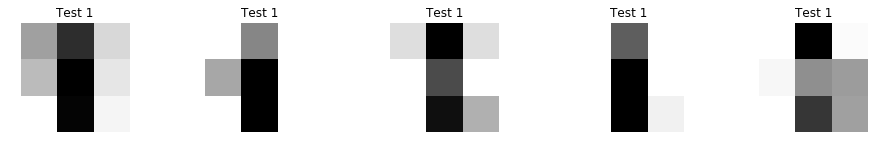

In [109]:
dataset_train,dataset_test = buildDataSet(basepicture, nb_image_per_class=1000, noise_amplitude=0.5)
print(dataset_train[0].shape)
print(dataset_test[0].shape)
print("dataset train : 4x",dataset_train[0].shape)
print("dataset test : 4x",dataset_test[0].shape)
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)


### Definition du modele de similarité

In [110]:
def build_network(input_shape):
    # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                   kernel_initializer='he_uniform', kernel_regularizer=l2(2e-4)))
    
    network.add(Flatten())
    network.add(Dense(2, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(input_shape, network, margin=0.2):
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [111]:
network = build_network((3,3,1)) 
network_train = build_model((3,3,1),network,margin=0.2)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='01 model.png')
print(network_train.metrics_names)
n_iteration=0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 2)            770         anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

![alt text](01 model.png "")   



In [112]:
featured_img = network.predict(np.zeros((1,3,3,1)))
print(featured_img,np.sum(np.square(featured_img)))

[[0. 0.]] 0.0


### Train

In [113]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- array containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    n_classes = len(dataset_train)
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, n_classes) 
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(n_classes,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,n_classes)) % n_classes
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, m)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

Batch width 3
Shapes in the batch A:(2, 3, 3, 1) P:(2, 3, 3, 1) N:(2, 3, 3, 1)


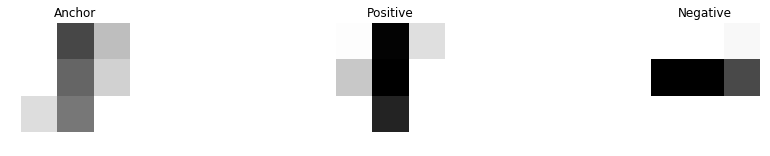

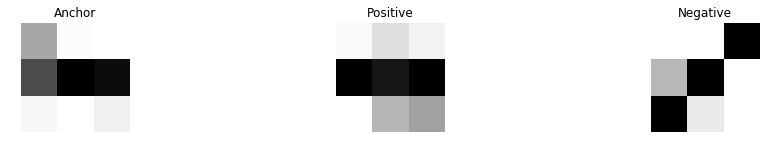

In [114]:
triplets = get_batch_random(2)
print("Batch width",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)

In [124]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 14000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

### Validation
(Simplified version)
We want to evaluate the test image vs all base class images. le meilleur score de l'evaluation est sur la bonne classe => resultat bon sinon on considere que c'est faux



In [116]:
def get_reference_encodings(network):
    '''
    Computes encodings of base images with current model
    
    
    Returns encodings with shape (4,15)
    '''
    ref_encoding = network.predict(basepicture)
    return ref_encoding

def evaluation(network, nbimage_test_per_class):
    '''
    Evaluate our model with our test set
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (nbimage_test,N,N)
        accuracy : accuracy
        avg_positive_distance : average distance between the test images and their correct class
        avg_negative_distance : average distance between the test images and their incorrect class
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    scores = np.zeros((nbimage_test_per_class,N,N))
    n_correct = 0
    negative_distance = 0
    positive_distance = 0
    dummy = np.zeros((1,w,h,c))
    
    #Generates the encoding of all reference classes with current model
    ref_encoding = get_reference_encodings(network)
    
    for i in range(nbimage_test_per_class):
        #On teste toutes les categories a la fois
        for n in range(N):
            #Choisi une image pour cette classe n
            idx = np.random.randint(0, dataset_test[n].shape[0]) 
            
            #generates encoding for this test pic
            test_encoding = network.predict(np.expand_dims(dataset_test[n][idx,:,:,:], axis=0))
            
            #Compute distance between this test_encoding and all other reference encodings
            for refclass in range(N):
                scores[i,n,refclass] = np.sum(np.square(test_encoding - ref_encoding[refclass,:]))
                
                if (n == refclass):
                    #store distance with the correct class
                    positive_distance += scores[i,n,refclass]
                else:
                    #store distance with the incorrect class
                    negative_distance += scores[i,n,refclass]
                
            #If the argmin is the current class n, it's a correct prediction
            if (np.argmin(scores[i,n,:]) == n):
                n_correct += 1
                
            
                
    accuracy = (100.0 * n_correct / nbimage_test_per_class / N)
    avg_positive_distance = positive_distance / nbimage_test_per_class / N
    avg_negative_distance = negative_distance / nbimage_test_per_class / N
    return scores,accuracy,avg_positive_distance,avg_negative_distance



def evaluation_onepic(network, image):
    '''
    Get the scores for one test image
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    scores = np.zeros((N))
    dummy = np.zeros((1,w,h,c))
    
    #Generates the encoding of all reference classes with current model
    ref_encoding = get_reference_encodings(network)
    
    #generates encoding for this test pic
    test_encoding = network.predict(image)
            
    #Compute distance between this test_encoding and all other reference encodings
    for refclass in range(N):
        scores[refclass] = np.sum(np.square(test_encoding - ref_encoding[refclass,:]))
                
    return scores

def drawEvaluationOnePic(network,image):
    '''
    Compute and draw the distances between test image and all base images 
    
    '''
    #compute encodings and score
    distances = evaluation_onepic(network,image)
    
    #Prepare the figure
    fig=plt.figure(figsize=(16,2))
    subplot = fig.add_subplot(1,5,1)
    axis("off")
    plt.imshow(image[0,:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text("Test image")
    mindist = np.min(distances)
    for n in range(4):
        subplot = fig.add_subplot(1,5,n+2)
        axis("off")
        plt.imshow(basepicture[n,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text(("{1}\n({2})".format(n,distances[n],mindist-distances[n])))

def drawOriginEvaluation(network):
    for n in range(4):
        drawEvaluationOnePic(network,np.expand_dims(basepicture[n,:,:,:],axis=0))
        
def DrawTestImage(network,classe,number):
    drawEvaluationOnePic(network,np.expand_dims(dataset_test[classe][number,:,:,:],axis=0))

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    ref_images = np.zeros((nb_classes,3,3,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,2])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def draw_embeddings(network):
    basepredict = network.predict(basepicture)
    print(basepredict)
    plt.scatter(basepredict[:,0],basepredict[:,1])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    for i in range(4):
        plt.annotate(i, (basepredict[i,0], basepredict[i,1]))

    for i in range(4):
        preds = network.predict(dataset_test[i])
        plt.scatter(preds[:,0],preds[:,1])

[[0.23381905 0.97228014]
 [0.7960229  0.60526645]
 [0.98189044 0.18944992]
 [0.57820314 0.8158929 ]]


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:138: MatplotlibDeprecationWarning:

numpy.hypot



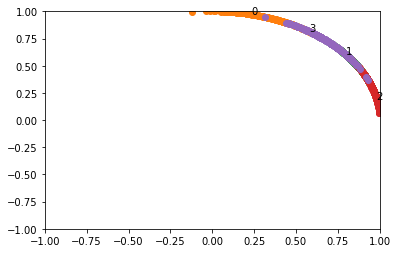

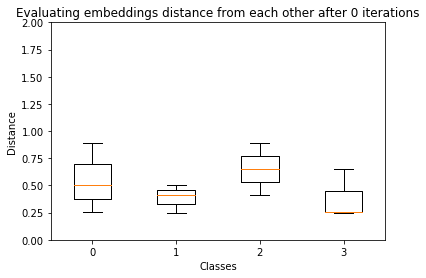

In [117]:
draw_embeddings(network)
draw_interdist(network,n_iteration)


In [125]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    triplets = get_batch_random(batch_size)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{2}] Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0,n_iteration))
        print("Train Loss: {0}".format(loss)) 
        scores,val_acc,avg_positive_distance,avg_negative_distance = evaluation(network, n_val)
        print("Test accuracy: {0}, Average P_distance {1}, Avergage N_distance {2}, Ratio P/N={3}".format(val_acc,avg_positive_distance,avg_negative_distance,avg_positive_distance/avg_negative_distance))
        

Starting training process!
-------------------------------------

 ------------- 

[7000] Time for 1000 iterations: 0.08129813273747762 mins
Train Loss: 0.028138888999819756
Test accuracy: 99.0, Average P_distance 0.04541652150136715, Avergage N_distance 7.5332652965337035, Ratio P/N=0.0060287962408896905

 ------------- 

[8000] Time for 2000 iterations: 0.17801277637481688 mins
Train Loss: 0.027694635093212128
Test accuracy: 99.4, Average P_distance 0.04600327989868403, Avergage N_distance 7.660984728038311, Ratio P/N=0.006004878162766385

 ------------- 

[9000] Time for 3000 iterations: 0.2732238570849101 mins
Train Loss: 0.027253422886133194
Test accuracy: 99.5, Average P_distance 0.04258885823977248, Avergage N_distance 7.687640822410583, Ratio P/N=0.0055399125978440366

 ------------- 

[10000] Time for 4000 iterations: 0.36907493670781455 mins
Train Loss: 0.026819150894880295
Test accuracy: 99.9, Average P_distance 0.04032984334623021, Avergage N_distance 7.670470276057721, Rat

Test accuracy: 99.25, Average P_distance 0.05600056147231619, Avergage N_distance 7.114649597313255


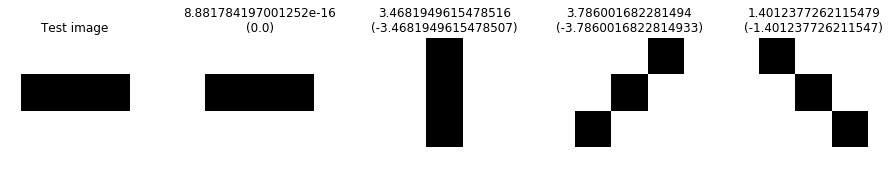

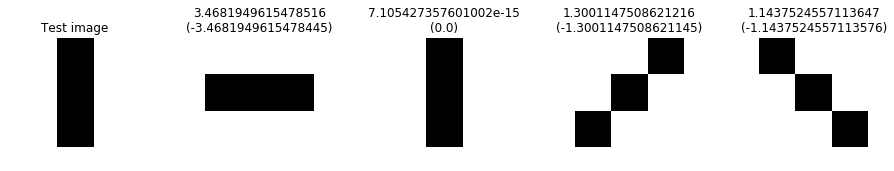

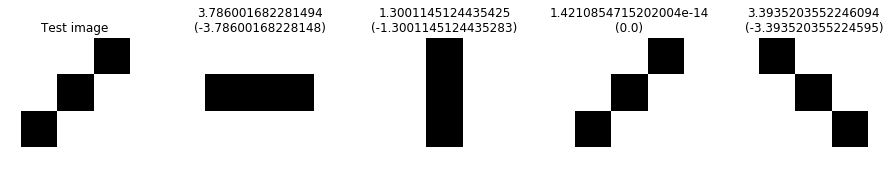

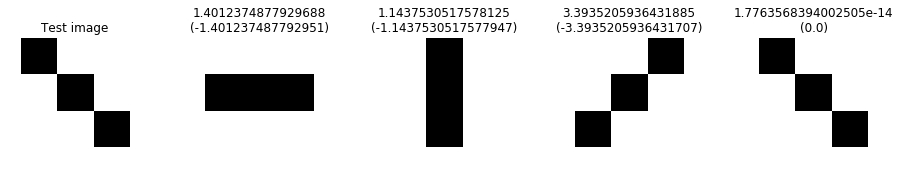

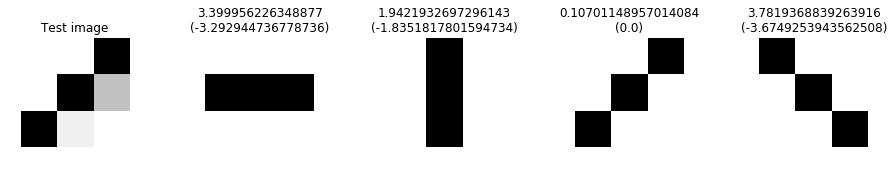

In [119]:
drawOriginEvaluation(network)

DrawTestImage(network,classe=2,number=2)
scores,val_acc,avg_positive_distance,avg_negative_distance = evaluation(network,200)
print("Test accuracy: {0}, Average P_distance {1}, Avergage N_distance {2}".format(val_acc,avg_positive_distance,avg_negative_distance))

[[-0.9006592   0.43452618]
 [ 0.95623416  0.29260254]
 [ 0.6087287  -0.7933784 ]
 [ 0.1449556   0.9894381 ]]


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:138: MatplotlibDeprecationWarning:

numpy.hypot



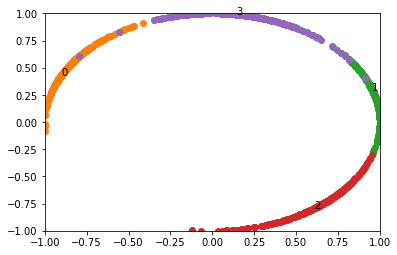

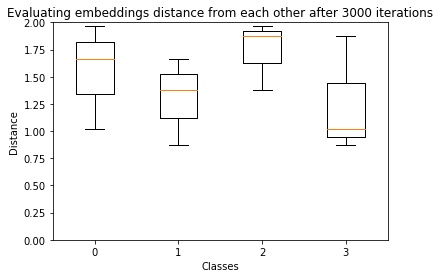

In [120]:
draw_embeddings(network)
draw_interdist(network,n_iteration)


[[-0.9606586   0.27773196]
 [ 0.96850306  0.24900177]
 [ 0.49299353 -0.870033  ]
 [ 0.10451555  0.9945232 ]]


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:138: MatplotlibDeprecationWarning:

numpy.hypot



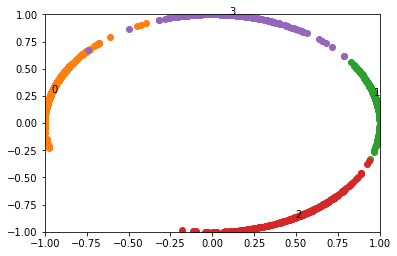

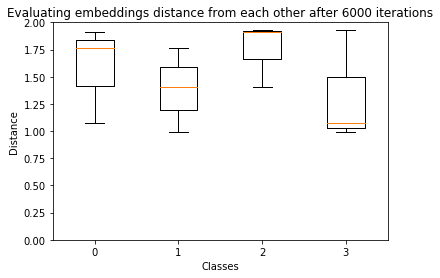

In [122]:
draw_embeddings(network)
draw_interdist(network,n_iteration)

[[-0.99999905 -0.00134874]
 [ 0.9689088   0.2474179 ]
 [ 0.25984755 -0.96564966]
 [ 0.09698062  0.9952863 ]]


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:138: MatplotlibDeprecationWarning:

numpy.hypot



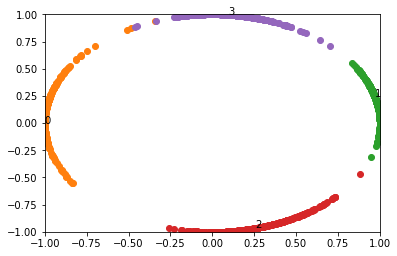

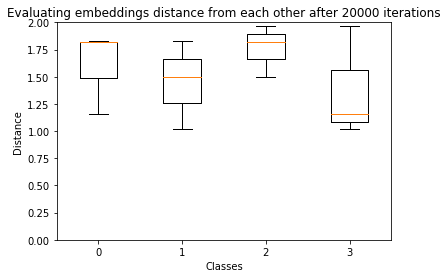

In [126]:
draw_embeddings(network)
draw_interdist(network,n_iteration)